In [1]:
import itertools
import hashlib
import pandas as pd
import numpy as np
import json

from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions, rdmolfiles, rdmolops

from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

import template_utils.coley_utils_rdchiral as cc
import rdc

def remove_atommaps(mols):
    products = []
    for product in mols.split('.'):
        m = Chem.MolFromSmiles(product)
        for atom in m.GetAtoms():
            atom.SetAtomMapNum(0)
        products.append(Chem.MolToSmiles(m))
    return '.'.join(products)

class Reaction:
	"""Class for reaction pre-processing and automatic template extraction.
	
	Capabilities
	- Agent removal from reaction smiles
	- Splitting reaction smiles into: reactants, agents, products
	- Converting reactant, agents, products into RDKit mols
	- Checking sanitization of reaction smiles
	- Checking completness of reaction smiles 
	- Checking for the equivelence of reactants and products
	- Checking if the product is in the reactants
	- Generation of a RInChI like string
	- Generation of a hashed reaction
	- Check for partial mapping
	- Generation of reaction templates with differing radii
	- Substructure search a reaction for a given template
	- Validate the retro-template
	- Check whether a given template leads to an outcome
	- Asses the retro-template in terms of selectivity 
	- Create a hash from a template

	Parameters:
		rsmi (str): Atom-mapped Reaction SMILES in the form
			reactants>agents>products
			reactants.agents>>products
			If the Reaction SMILES are not Atom-mapped templates will not be extracted

	Notes:
		- Template validation/checking should only be called after the template has been generated
		- Validation works for the retro direction but not forward
	"""
	def __init__(self, rsmi, rid=None):
		"""Accquires necessary information upon initalisation.

		Parameters:
			rsmi (str): Atom-mapped Reaction SMILES in the form
				reactants>agents>products
				reactants.agents>>products
				If the Reaction SMILES are NOT Atom-mapped templates will not be extracted
            rid (str): Optional, reaction identifier
		"""
		self.rsmi = rsmi
		self.rid = rid
		self.rsmi, self.clean_rsmi = self.clean_reaction()
		
		self.get_reactant_list()
		self.get_agent_list()
		self.get_product_list()
		self.get_reactant_mol_list()
		self.get_product_mol_list()
		

	def clean_reaction(self):
		"""This function takes reaction smiles of the form:
		a.b.c>d.e.f>g.h
		and changes them to the form:
		a.b.c.d.e.f>>g.h
		
		Unmapped reactants are moved to the agents to create the form:
		mapped_reactants>unmapped_reactants>product

		Returns:
			rsmi (str): Reaction SMILES in the form a.b.c.d.e.f>>g.h
			clean_rsmi (str): Reaction SMILES in the form mapped_reactants>unmapped_reactants>product
		"""
		#Split into Reactants and Products
		split_reaction = self.rsmi.split(">")
		#Get reactant and product smiles string with . separators 
		reactants = split_reaction[0]
		self.agents = split_reaction[1]
		self.products = split_reaction[2]
		if len(self.agents) == 0:
			self.reactants = reactants
		else:
			self.reactants = '.'.join([reactants, self.agents])
		self.rsmi = '>>'.join([self.reactants, self.products])
		reaction = rdChemReactions.ReactionFromSmarts(self.rsmi)
		reaction.RemoveUnmappedReactantTemplates()
		self.clean_rsmi = rdChemReactions.ReactionToSmiles(reaction)
		return self.rsmi, self.clean_rsmi
	
	def get_reactant_list(self):
		"""
		Returns: 
			reactant_list (list): a list of Reactant SMILES
		"""
		self.reactant_list = self.reactants.split('.')
		return self.reactant_list
	
	def get_agent_list(self):
		"""
		Returns: 
			agent_list (list): a list of Agent SMILES
		"""
		self.agent_list = self.agents.split('.')
		return self.agent_list
	
	def get_product_list(self):
		"""
		Returns: 
			product_list (list): a list of Product SMILES
		"""
		self.product_list = self.products.split('.')
		return self.product_list
	
	def get_reactant_mol_list(self):
		""" Given a list of smiles strings, creates a list of RDKit molecules.
		Returns: 
			reactant_mol_list (list): a list of Reactant RDKit Mol objects
		"""
		self.reactant_mol_list = cc.mols_from_smiles_list(cc.replace_deuterated(self.reactants).split('.'))
		return self.reactant_mol_list
	
	def get_product_mol_list(self):
		""" Given a list of smiles strings, creates a list of RDKit molecules.
		Returns: 
			product_mol_list (list): a list of Product RDKit Mol objects
		"""
		self.product_mol_list = cc.mols_from_smiles_list(cc.replace_deuterated(self.products).split('.'))
		return self.product_mol_list

	def sanitization_check(self):
		"""Checks whether the Reactant and Product Mol Objects can be sanitized in RDKit.
		Returns: 
			True (bool): If sanitization is successful
			None: If cannot be sanitized
		"""
		#If molecules can't be sanitized by RDKit neglect the reaction
		try:
			for i in range(len(reactants)):
				reactants[i] = AllChem.RemoveHs(reactants[i]) # *might* not be safe
			for i in range(len(products)):
				products[i] = AllChem.RemoveHs(products[i]) # *might* not be safe
			[Chem.SanitizeMol(mol) for mol in reactants + products] # redundant w/ RemoveHs
			[mol.UpdatePropertyCache() for mol in reactants + products]
			return True
		except Exception as e:
			# can't sanitize -> skip
			print('Could not load SMILES or sanitize')
			return None
	
	def incomplete_reaction(self):
		"""Checks a given reaction smiles for completeness i.e. no products or no reactants.
		Returns:
			True (bool): If the reaction has no reactants or products
			False (bool): If the reaction has reactants or products
		"""
		if len(self.reactant_list) == 0 or len(self.product_list) == 0:
			return True
		else:
			return False
		
	def equivalent_reactant_product_set(self):
		"""Checks whether the set of reactants and products are equivalent. i.e. There is no
		change in between the reactants and products - No reaction has occured/Purification
		
		Accounts for variations in ordering of the individual components by checking all 
		permutations.

		Compares InChIs to rule out possible variations in SMILES notation.

		Returns:
			True (bool): If the reactants and products are equivalent
			False (bool): If the reactants and products are NOT equivalent
		"""
		reactant_subsets = itertools.permutations(self.reactant_list,len(self.product_list))
		reactant_subsets = ['.'.join(x) for x in reactant_subsets]
		match = False
		for reactant in reactant_subsets:
			if Chem.MolToInchi(Chem.MolFromSmiles(reactant)) == Chem.MolToInchi(Chem.MolFromSmiles(self.products)):
				match = True
				break
			else: 
				continue
		return match
	
	def product_in_reactant_set(self):
		"""Checks to see if the product appears in the reactant set.

		Compares InChIs to rule out possible variations in SMILES notation.

		Returns:
			True (bool): If the product is present in the reactants set.
			False (bool): If the product is NOT present in the reactants set.
		"""
		reactant_inchi = [Chem.MolToInchi(Chem.MolFromSmiles(reactant)) for reactant in self.reactant_list]
		product_inchi = [Chem.MolToInchi(Chem.MolFromSmiles(product)) for product in self.product_list]
		if len(list(set(reactant_inchi) & set(product_inchi))) != 0:
			print("Product appears in the set of reactants - No reaction")
			return True
		else: 
			return False
	
	def generate_pseudoRInChI(self):
		"""Generates a Reaction InChI like string from the given smiles.
		
		Concatenates Reactant and Product InChI strings, and replaces elements to make the string more 'InChI like'

		Returns:
			pseudo_rinchi (str): RInChI like string (It cannot be parsed as an RInChI)
		
		Notes:
			Currently Unused
		"""
		reactant_inchi = Chem.MolToInchi(Chem.MolFromSmiles(self.reactants))
		product_inchi = Chem.MolToInchi(Chem.MolFromSmiles(self.products))
		product_inchi = product_inchi.replace('InChI=1S/', '')
		pseudo_rinchi = '<>'.join([reactant_inchi, product_inchi])
		pseudo_rinchi = pseudo_rinchi.replace('.', '!')
		pseudo_rinchi = pseudo_rinchi + '/d+'
		return pseudo_rinchi
	
	def generate_concatenatedRInChI(self, hash_inchi=True):
		"""Generates and concatenates the InChI for the reactants and products.
		
		Parameters:
			hash (bool): if hash is True (default), 
				returns the hash of the inchi after concatenating instead of the concatenated InChI strings
		
		Returns:
			concatenated_rinchi (str): if hash is False
			hashed_inchi (str): if hash is True

		Notes:
			Hashed InChIs are used in identifying duplicate reactions. InChIs are order invariant unlike SMILES.
		"""
		reactant_inchi = Chem.MolToInchi(Chem.MolFromSmiles(remove_atommaps(self.reactants)))
		product_inchi = Chem.MolToInchi(Chem.MolFromSmiles(remove_atommaps(self.products)))
		self.concatenated_rinchi = '++'.join([reactant_inchi, product_inchi])

		if hash_inchi:
			self.hashed_inchi = hashlib.sha224(self.concatenated_rinchi.encode('utf8')).hexdigest()
			return self.hashed_inchi
		else: 
			return self.concatenated_rinchi
	
	def generate_reaction_identifier(self):
		"""Concatenates the InChI for the reactants and products, and hashes the resulting string with the
		reaction id.
		
		Can be used to differentiate between different reaction records with source accounted for.
		
		Returns:
			hashed_rid (str): Hash based on the reaction (reactant + product) and reaction id.

		Notes:
			Hashed InChIs are used in identifying duplicate reactions. InChIs are order invariant unlike SMILES.
		"""
		reactant_inchi = Chem.MolToInchi(Chem.MolFromSmiles(self.reactants))
		product_inchi = Chem.MolToInchi(Chem.MolFromSmiles(self.products))
		self.concatenated_rinchi = '++'.join([reactant_inchi, product_inchi])

		self.hashed_rid = hashlib.sha224(self.concatenated_rinchi.encode('utf8') + self.id.encode('utf8')).hexdigest()
		return self.hashed_rid

	def has_partial_mapping(self):
		"""Check product atom mapping. 

		Returns:
			True (bool): If the number of atoms in product with mapping is less than the number of atoms in the product.
			False (bool): If the number of atoms in product with mapping equals the number of atoms in the product.
		"""
		for product in self.product_mol_list:
			if sum([atom.HasProp('molAtomMapNumber') for atom in product.GetAtoms()]) < len(product.GetAtoms()):
				print('Not all product atoms have atom mapping')
				return True
			else: 
				return False
	
	def generate_reaction_template(self, radius=1):
		"""Extracts the forward(canonical) and retro reaction template with the specified radius.

		Parameters:
			radius (int): the radius refers to the number of atoms away from the reaction centre to be extracted (the enivronment)
				i.e. radius = 1 (default) returns the first neighbours around the reaction centre
			stereochemistry (bool): If True, stereochemistry will be retained in the extracted template. If False (default)
				stereochemistry will not be considered explicitly.

		Returns:
			canonical_template (str): the template SMIRKS as a string
			retro_template (str): the template SMIRKS as a string

		References:
			Uses a modified version of:
			https://github.com/connorcoley/ochem_predict_nn/blob/master/data/generate_reaction_templates.py
			https://github.com/connorcoley/rdchiral/blob/master/templates/template_extractor.py
		"""
		reactants = self.reactant_mol_list
		products = self.product_mol_list

		#Check reaction for invalidity
		try:
			if self.product_in_reactant_set():
				return None
			elif None in reactants + products:
				print('Could not parse all molecules in reaction, skipping')
				return None
			else: 
				pass
		except Exception as e:
			print(e)
			print('Reaction is not suitable for processing or invalid')
			return None
		
		# try to sanitize molecules
		# TODO: could merge with sanitize reaction
		try:
			for i in range(len(reactants)):
				reactants[i] = AllChem.RemoveHs(reactants[i]) # *might* not be safe
			for i in range(len(products)):
				products[i] = AllChem.RemoveHs(products[i]) # *might* not be safe
			[Chem.SanitizeMol(mol) for mol in reactants + products] # redundant w/ RemoveHs
			[mol.UpdatePropertyCache() for mol in reactants + products]
		except Exception as e:
			#can't sanitize -> skip
			print(e)
			print('Could not load SMILES or sanitize')
			return None

		# Similar to has_partial mapping 
		# TODO: could merge with has_partial_mapping
		are_unmapped_product_atoms = False
		extra_reactant_fragment = ''
		for product in products:
			prod_atoms = product.GetAtoms()
			if sum([a.HasProp('molAtomMapNumber') for a in prod_atoms]) < len(prod_atoms):
				if cc.VERBOSE: print('Not all product atoms have atom mapping')
				are_unmapped_product_atoms = True
		
		if are_unmapped_product_atoms: # add fragment to template
			for product in products:
				# Get unmapped atoms
				unmapped_ids = [
					a.GetIdx() for a in prod_atoms if not a.HasProp('molAtomMapNumber')
				]
				if len(unmapped_ids) > cc.MAXIMUM_NUMBER_UNMAPPED_PRODUCT_ATOMS:
					# Skip this example - too many unmapped product atoms!
					return
				# Define new atom symbols for fragment with atom maps, generalizing fully
				atom_symbols = ['[{}]'.format(a.GetSymbol()) for a in prod_atoms]
				# And bond symbols...
				bond_symbols = ['~' for b in product.GetBonds()]
				if unmapped_ids:
					extra_reactant_fragment += AllChem.MolFragmentToSmiles(
						product, unmapped_ids, 
						allHsExplicit = False, isomericSmiles = cc.USE_STEREOCHEMISTRY, 
						atomSymbols = atom_symbols, bondSymbols = bond_symbols
					) + '.'
			if extra_reactant_fragment:
				extra_reactant_fragment = extra_reactant_fragment[:-1]
				if cc.VERBOSE: print('    extra reactant fragment: {}'.format(extra_reactant_fragment))

			# Consolidate repeated fragments (stoichometry)
			extra_reactant_fragment = '.'.join(sorted(list(set(extra_reactant_fragment.split('.')))))

		#Extract template
		try:
		#Calculate changed atoms
			changed_atoms, changed_atom_tags, err = cc.get_changed_atoms(reactants=reactants, products=products)
			if err: 
				print('Could not get changed atoms')
				return None
			elif not changed_atom_tags:
				print('No atoms changed? - No reaction/Error')
				return None
			else: 
				pass

			#Get fragments for reactants
			reactant_fragments, intra_only, dimer_only = cc.get_fragments_for_changed_atoms(reactants, changed_atom_tags, 
				radius = radius, expansion = [], category = 'reactants')
			#Get fragments for products %%!
			#(WITHOUT matching groups but WITH the addition of reactant fragments)
			product_fragments, _, _  = cc.get_fragments_for_changed_atoms(products, changed_atom_tags, 
						radius = radius, expansion = cc.expand_changed_atom_tags(changed_atom_tags, reactant_fragments),
						category = 'products')
			#Report transform
			rxn_string = '{}>>{}'.format(reactant_fragments, product_fragments)
			canonical_template = cc.canonicalize_transform(rxn_string)
			# Change from inter-molecular to intra-molecular 
			canonical_template_split = canonical_template.split('>>')
			self.canonical_template = canonical_template_split[0][1:-1].replace(').(', '.') + \
				'>>' + canonical_template_split[1][1:-1].replace(').(', '.')

			reactants_string = canonical_template.split('>>')[0]
			products_string  = canonical_template.split('>>')[1]

			self.retro_template = products_string + '>>' + reactants_string

			# Load into RDKit - same as validate template
			# TODO: Merge with validation
			rxn = AllChem.ReactionFromSmarts(self.retro_template)
			if rxn.Validate()[1] != 0: 
				print('Could not validate reaction successfully')
				print('retro_template: {}'.format(self.retro_template))
		except Exception as e:
			print(e)
			print('Template could not be extracted')
			return None

		return self.canonical_template, self.retro_template
	
	def check_retro_template_substructure(self, template, reactants, products):
		"""Checks whether a template SMIRKS is a substructure of a Reaction. 
		Reconstructs the reaction from the reactants and products.

		Parameters:
			template (str): Retro-reaction template SMIRKS pattern
			reactants (str): Reactant SMILES string i.e. reactant1.reactant2.reactant3
			products (str): Product SMILES string i.e. product1.product2.product3

		Returns:
			True (bool): If Reaction and Template substructure match is found
			False (bool): If there is no match between Template and the reaction
		"""
		retro_template_product = template.split('>>')[0]
		retro_product= Chem.MolFromSmarts(retro_template_product)
		reaction_product = Chem.MolFromSmiles(products)
		retro_template_reactants = template.split('>>')[1]
		retro_reactants = Chem.MolFromSmarts(retro_template_reactants)
		reaction_reactants = Chem.MolFromSmiles(reactants)
		if reaction_product.HasSubstructMatch(retro_product) and reaction_reactants.HasSubstructMatch(retro_reactants):
			return True
		else: 
			return False
	
	def validate_retro_template(self, template):
		"""Checks whether the template is valid in RDKit.
		
		Parameters:
			template (str): Retro-reaction template SMIRKS pattern

		Returns:
			None: If the template cannot be validated in RDKit
			True (bool): If the template can be validated in RDKit
		"""
		template = rdChemReactions.ReactionFromSmarts(template)
		if template.Validate()[1] != 0:
			print('Could not validate template - Invalid')
			return None
		else: 
			return True
	
	def check_retro_template_outcome(self, template, products, save_outcome=True):
		"""Checks whether the template produces an outcome and stores it.

		Parameters:
			template (str): Retro-reaction template SMIRKS pattern
			product_mol_list (list): List of product molecules to be synthesised as RDKit Mols.
				Usually the list only has one member, the recorded product in the dataset, or user specified compound to be synthesised.
			save_outcome (bool): Speficifies whether to store the outcomes in the class-

		Assigns:
			retro_outcomes (obj):

		Returns:
			number of outcomes (int): the number of outcomes generated from application of the template
		"""
		# template = rdChemReactions.ReactionFromSmarts(template)
		# outcomes = template.RunReactants(product_mol_list)
		outcomes = rdc.rdchiralRunText(template, products)
		if save_outcome:
			self.retro_outcomes = outcomes
		else: 
			pass
		if len(outcomes) == 0:
			print("No transformation - invalid template")
			return len(outcomes)
		else: 
			return len(outcomes)
	
	def assess_retro_template(self, template, reactant_mol_list, retro_outcomes):
		"""Checks whether the recorded reactants belong to the set of generated precursors.

		Parameters:
			template (str): Retro-reaction template SMIRKS string
			reactant_mol_list (list): List of the recorded reactant molecules to be cross-checked as RDKit Mols.
			retro_outcomes (obj): outcome list from the function 'check_retro_template_outcome()' or object generated from RdKit 'RunReactants'.
			stereochemistry (bool): If True, stereochemistry will be considered when matching generated and recorded outcomes. 
				If False (default) stereochemistry will not be considered and matches will be done on the scaffold.
		
		Returns:
			selectivity (float): the fraction of generated precursors matching the recorded precursors
				i.e. 1.0 - match or match.match or match.match.match etc.
					0.5 - match.none or match.none.match.none etc.
					0.0 - none

		Notes:
			Requires an outcome list from the function 'check_retro_template_outcome()'
		"""
		template = rdChemReactions.ReactionFromSmarts(template)

		if cc.USE_STEREOCHEMISTRY is False:
			reactant_mol_list = []
			for smiles in self.reactant_list:
				if not smiles: 
					continue
				reactant_mol_list.append(rdmolfiles.MolFromSmiles(smiles.replace('@','')))
		else: 
			reactant_mol_list = reactant_mol_list

		reactant_inchi = [Chem.MolToInchi(reactant) for reactant in reactant_mol_list]
		precursor_set = []
		for outcome_set in retro_outcomes:
			if cc.USE_STEREOCHEMISTRY is False:
				outcome_set_inchi = [Chem.MolToInchi(Chem.MolFromSmiles(outcome.replace('@',''))) for outcome in outcome_set.split('.')]
			else:
				outcome_set_inchi = [Chem.MolToInchi(Chem.MolFromSmiles(outcome)) for outcome in outcome_set.split('.')]
			precursor_set.append(outcome_set_inchi)
		assessment = []
		for precursor in precursor_set:
			#There must be a match between the generated outcomes and recorded reactants 
			if len(list(set(precursor) & set(reactant_inchi))) != 0:
				assessment.append(2)
			#No match or error
			elif len(list(set(precursor) & set(reactant_inchi))) == 0:
				assessment.append(1)
			else:
				print("Template error")
				assessment.append(0)
		
		#Quantify the level of selectivity, if an error has occured set to 0
		if assessment.count(0) != 0:
			return 0
		else:
			selectivity = assessment.count(2)/len(assessment)
			return selectivity

	def hash_template(self, template):
		""" Hashes the reaction template.

		Parameters:
			template (str): template SMIRKS pattern
		
		Returns:
			hashed_template (str): sha224 hash of the template SMIRKS pattern
		"""
		template = rdChemReactions.ReactionFromSmarts(template)
		rdChemReactions.RemoveMappingNumbersFromReactions(template)
		template = rdChemReactions.ReactionToSmiles(template)
		self.hashed_template = hashlib.sha224(template.encode('utf8')).hexdigest()
		return self.hashed_template

class Binarizer:
	"""Allows conversion between SMILES and RDKit binary format
	"""
	def to_binary_value(self, component):
		"""Gets the biary representation of a reaction component from the SMILES.
		Also works if the SMILES are separated by a '.' i.e. the reactants

		Parameters:
			component (str): SMILES string of the component species

		Returns:
			binary_mol (bytes): byte string representation of the molecule
		"""
		component_mol = Chem.MolFromSmiles(component)
		return component_mol.ToBinary()
	
	def from_binary_value(self, component):
		"""Retrieves the SMILES representation of a reaction component from binary.

		Parameters:
			component (bytes): byte string representation of the molecule
		
		Returns:
			component (str): SMILES string of the component species
		"""
		return Chem.MolToSmiles(Chem.Mol(component))
	
	def reaction_smiles_from_binary(self, reactants, products):
		"""Returns the reaction SMILES from the reactants and products stored in binary

		Parameters:
			reactants (bytes): byte string representation of the reactants
			products (bytes): byte string representation of the products
		
		Returns:
			reaction (str): SMILES string of the reaction
		"""
		reac = self.from_binary_value(reactants)
		prod = self.from_binary_value(products)
		return '>>'.join([reac, prod])
	
	def template_to_binary(self, template):
		"""Gets the binary representation of a reaction/transform/template

		Parameters:
			template (str): template SMIRKS pattern

		Returns:
			template (bytes): byte string representation of the template
		"""
		left = Chem.MolFromSmarts(template.split('>>')[0]).ToBinary()
		right = Chem.MolFromSmarts(template.split('>>')[1]).ToBinary()
		return b'>>'.join([left, right])
	
	def template_from_binary(self, template):
		"""Gets the SMILES representation of a reaction/transform/template

		Parameters:
			template (bytes): byte string representation of the template

		Returns:
			template (str): template SMIRKS pattern
		"""
		left = Chem.MolToSmarts(Chem.Mol(template.split(b'>>')[0]))
		right = Chem.MolToSmarts(Chem.Mol(template.split(b'>>')[1]))
		return '>>'.join([left, right])

class Parsers:
	"""Allows parsing of different data formats into the required format.
	Should be added to and modified for each new data source.

	Required output format:
	'pd.DataFrame(columns=['rsmi', 'ID', 'classification_id', 'classification'])'

	Can be extended to incorporate more information if/when available. Changes must be reflected in the extraction script to allow
	proper parsing.
	"""

	def import_USPTO(self, data):
		"""Loads, sorts, crudely curates the USPTO 1976-2016 data.

		Parameters:
			datafile (csv file): a csv file containing the required data.
		
		Returns:
			dataframe (pd.DataFrame): pd.DataFrame(columns=['rsmi', 'ID', 'classification_id', 'classification'])
		"""
		df = pd.read_csv(data, index_col=0, header=None, names=['rsmi', 'patent_id', 'para_num', 'year', 'classification', 'text_yield', 'calc_yield'], sep=';', engine='python')
		USPTO_data = pd.DataFrame(columns=['rsmi', 'ID', 'classification_id', 'classification'])
		for index, row in df.iterrows():
			try:
				ID = str(row['patent_id']) + ";" + str(row['para_num']) + ";" + str(row['year'])
				#print(row['rsmi'])
				if len(row['rsmi'].split()) == 0:
					continue
				line = [row['rsmi'].split()[0], ID, float('nan'), row['classification']]
				df2 = pd.DataFrame([line], columns=['rsmi', 'ID', 'classification_id', 'classification'])
				USPTO_data = USPTO_data.append(df2, sort = False)
			except:
				continue
		return USPTO_data

In [2]:
# Reaction examples, reactions 1 & 2 are equivalent (re-ordered), reaction 3: product in reactant set, reactions 4,5,6: unique
reaction1 = "Br[CH2:12][c:13]1[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]1.O=C([O-])[O-].[Cl:1][c:2]1[n:3][c:4]2[c:5]([nH:6][cH:7][n:8]2)[c:9]([NH2:10])[n:11]1.[K+].[K+]>CN(C)C=O>[Cl:1][c:2]1[n:3][c:4]2[c:5]([n:6][cH:7][n:8]2[CH2:12][c:13]2[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]2)[c:9]([NH2:10])[n:11]1"
reaction2 = "[K+].[K+].Br[CH2:12][c:13]1[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]1.O=C([O-])[O-].[Cl:1][c:2]1[n:3][c:4]2[c:5]([nH:6][cH:7][n:8]2)[c:9]([NH2:10])[n:11]1.CN(C)C=O>>[Cl:1][c:2]1[n:3][c:4]2[c:5]([n:6][cH:7][n:8]2[CH2:12][c:13]2[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]2)[c:9]([NH2:10])[n:11]1"
reaction3 = "[Cl:1][c:2]1[n:3][c:4]2[c:5]([n:6][cH:7][n:8]2[CH2:12][c:13]2[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]2)[c:9]([NH2:10])[n:11]1.Br[CH2:12][c:13]1[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]1.O=C([O-])[O-].[Cl:1][c:2]1[n:3][c:4]2[c:5]([nH:6][cH:7][n:8]2)[c:9]([NH2:10])[n:11]1.[K+].[K+]>CN(C)C=O>[Cl:1][c:2]1[n:3][c:4]2[c:5]([n:6][cH:7][n:8]2[CH2:12][c:13]2[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]2)[c:9]([NH2:10])[n:11]1"
reaction4 = "Br[CH:16]([c:17]1[cH:18][cH:19][cH:20][cH:21][cH:22]1)[C:23]([O:24][CH2:25][CH3:26])=[O:27].O=C([O-])[O-].[K+].[K+].[O:1]([CH2:2][CH2:3][O:4][c:5]1[n:6][c:7]2[c:8]([nH:9][cH:10][n:11]2)[c:12]([NH2:13])[n:14]1)[CH3:15]>CN(C)C=O>[O:1]([CH2:2][CH2:3][O:4][c:5]1[n:6][c:7]2[c:8]([n:9][cH:10][n:11]2[CH:16]([c:17]2[cH:18][cH:19][cH:20][cH:21][cH:22]2)[C:23]([O:24][CH2:25][CH3:26])=[O:27])[c:12]([NH2:13])[n:14]1)[CH3:15]"
reaction5 = "CCN(CC)c1ccccc1.O.O=S(Cl)[Cl:12].O[CH:1]([c:2]1[cH:3][c:4]([C:8]([NH2:9])=[O:10])[cH:5][cH:6][cH:7]1)[CH3:11]>ClCCl>[CH:1]([c:2]1[cH:3][c:4]([C:8]([NH2:9])=[O:10])[cH:5][cH:6][cH:7]1)([CH3:11])[Cl:12]"
#wittig olefination
reaction6 = "C[Si](C)(C)[N-][Si](C)(C)C.O=[C:1]1[CH2:2][CH2:3][C@H:4]([C:5]([O:6][C:7]([CH3:8])([CH3:9])[CH3:10])=[O:11])[C@@H:12]([C:13]([O:14][CH2:15][c:16]2[cH:17][cH:18][cH:19][cH:20][cH:21]2)=[O:22])[CH2:23]1.[Na+]>Cc1ccccc1.[Br-].c1ccc([P+](c2ccccc2)(c2ccccc2)[CH3:24])cc1>[C:1]1(=[CH2:24])[CH2:2][CH2:3][C@H:4]([C:5]([O:6][C:7]([CH3:8])([CH3:9])[CH3:10])=[O:11])[C@@H:12]([C:13]([O:14][CH2:15][c:16]2[cH:17][cH:18][cH:19][cH:20][cH:21]2)=[O:22])[CH2:23]1"
reaction7 = "Cl.O=[Mn](=O)([O-])=[O:14].[Cl:1][c:2]1[c:3]([CH3:13])[cH:4][c:5]([O:11][CH3:12])[c:6]([N+:8](=[O:9])[O-:10])[cH:7]1.[K+].[OH2:15]>>[Cl:1][c:2]1[c:3]([C:13]([OH:14])=[O:15])[cH:4][c:5]([O:11][CH3:12])[c:6]([N+:8](=[O:9])[O-:10])[cH:7]1"

In [3]:
test = Reaction(reaction1)

In [4]:
test.rsmi

'Br[CH2:12][c:13]1[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]1.O=C([O-])[O-].[Cl:1][c:2]1[n:3][c:4]2[c:5]([nH:6][cH:7][n:8]2)[c:9]([NH2:10])[n:11]1.[K+].[K+].CN(C)C=O>>[Cl:1][c:2]1[n:3][c:4]2[c:5]([n:6][cH:7][n:8]2[CH2:12][c:13]2[cH:14][c:15]([C:19]([O:20][CH3:21])=[O:22])[cH:16][cH:17][cH:18]2)[c:9]([NH2:10])[n:11]1'

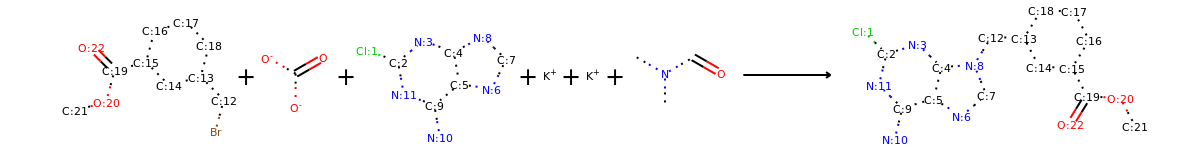

In [5]:
rdChemReactions.ReactionFromSmarts(test.rsmi)

In [6]:
len(test.rsmi.split('>')) > 3

False

In [7]:
len(test.product_list) > 1

False

In [8]:
test.incomplete_reaction()

False

In [9]:
test.equivalent_reactant_product_set()

False

In [10]:
test.generate_reaction_template(radius=1)

('Br-[CH2;D2;+0:1]-[c:2]1:[c:3]:[c:4](-[C:5](=[O;D1;H0:6])-[#8:7]-[C;D1;H3:8]):[c:9]:[c:10]:[c:11]:1.[#7;a:12]:[c:13]:[c:14]1:[nH;D2;+0:15]:[c:16]:[n;H0;D2;+0:17]:[c:18]:1:[#7;a:19]>>[#7;a:12]:[c:13]:[c:14]1:[n;H0;D2;+0:15]:[c:16]:[n;H0;D3;+0:17](-[CH2;D2;+0:1]-[c:2]2:[c:3]:[c:4](-[C:5](=[O;D1;H0:6])-[#8:7]-[C;D1;H3:8]):[c:9]:[c:10]:[c:11]:2):[c:18]:1:[#7;a:19]',
 '([#7;a:12]:[c:13]:[c:14]1:[n;H0;D2;+0:15]:[c:16]:[n;H0;D3;+0:17](-[CH2;D2;+0:1]-[c:2]2:[c:3]:[c:4](-[C:5](=[O;D1;H0:6])-[#8:7]-[C;D1;H3:8]):[c:9]:[c:10]:[c:11]:2):[c:18]:1:[#7;a:19])>>(Br-[CH2;D2;+0:1]-[c:2]1:[c:3]:[c:4](-[C:5](=[O;D1;H0:6])-[#8:7]-[C;D1;H3:8]):[c:9]:[c:10]:[c:11]:1).([#7;a:12]:[c:13]:[c:14]1:[nH;D2;+0:15]:[c:16]:[n;H0;D2;+0:17]:[c:18]:1:[#7;a:19])')

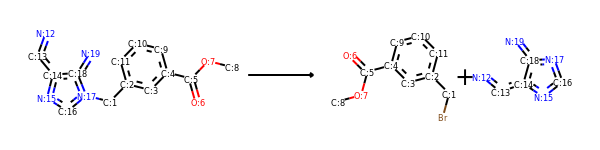

In [11]:
rdChemReactions.ReactionFromSmarts(test.retro_template)

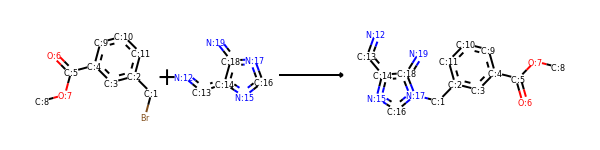

In [12]:
rdChemReactions.ReactionFromSmarts(test.canonical_template)

In [13]:
test.validate_retro_template(test.retro_template)

True

In [14]:
test.check_retro_template_outcome(test.retro_template, test.products, save_outcome=True)

1

In [15]:
test.retro_outcomes

['COC(=O)c1cccc(CBr)c1.c1nc2n[c:2]([Cl:1])nc([NH2:10])c2[nH]1']

In [16]:
test.assess_retro_template(test.retro_template, test.reactant_mol_list, test.retro_outcomes)

1.0

In [17]:
test.generate_concatenatedRInChI(hash_inchi=False)

'InChI=1S/C9H9BrO2.C5H4ClN5.C3H7NO.CH2O3.2K/c1-12-9(11)8-4-2-3-7(5-8)6-10;6-5-10-3(7)2-4(11-5)9-1-8-2;1-4(2)3-5;2-1(3)4;;/h2-5H,6H2,1H3;1H,(H3,7,8,9,10,11);3H,1-2H3;(H2,2,3,4);;/q;;;;2*+1/p-2++InChI=1S/C14H12ClN5O2/c1-22-13(21)9-4-2-3-8(5-9)6-20-7-17-10-11(16)18-14(15)19-12(10)20/h2-5,7H,6H2,1H3,(H2,16,18,19)'

In [18]:
test.generate_concatenatedRInChI(hash_inchi=True)

'd39c5b9846c01d5142fc33294ea9078e9a00d60aa66a069c4a9611d1'

In [19]:
test.hash_template(test.retro_template)

'd5843c40137bed2cddaef91ab2d862ae043ae8409ed62ee6d68f3b33'